In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, sample_col=[], feat_col=[], step_col=[], data_cols=[], target_col=[], to3d=True, splits=None, sort=False):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    step_col: used to indicate the order of the (time)steps when indicated in a column. It's only used to order data. 
    data_col: indicates where the data is located. If None, it means all columns (except the sample_col, feat_col, step_col and target_col)
    target_col: indicates the column/s where the target is.
    to3d: turns X to 3d (including univariate time series)
    sort: indicates whether the df needs to be sorted or not. If sorted, it will use sample col first, and feat_col second. For more complex sorting
          you'll need to pass a pre-sorted dataframe.
    """
    if feat_col: 
        assert sample_col, 'You must pass a sample_col when you pass a feat_col'
    sample_col, feat_col, target_col, data_cols, step_col = listify(sample_col), listify(feat_col), listify(target_col), listify(data_cols), listify(step_col)
    if not data_cols: 
        data_cols = [col for col in df.columns if col not in sample_col + feat_col + step_col + target_col]
    if sort:
        df = df.sort_values(sample_col + feat_col + step_col)
    
    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O': 
        X = X.astype(np.float32)
    n_samples = df[sample_col].nunique()[0] if sample_col else 1
    if to3d or feat_col is not None: 
        n_feats = df[feat_col].nunique()[0] if feat_col else 1
        X = X.reshape(n_samples, n_feats, -1)
    
    # y
    if target_col:
        y = df[target_col][df[sample_col[0]].ne(df[sample_col[0]].shift())].values.reshape(n_samples, -1)
        if y.shape[-1] <= 1: y = y.ravel()
    else: 
        y = None

    # Output
    if splits is None: return X, y
    else: return split_xy(X, y, splits)

def split_xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2Xy = df2xy
split_Xy = split_xy

In [ ]:
# Univariate
from io import StringIO
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort=True)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))

,sample_id,value_0,value_1,target
0,rob,2,3,hot
1,alice,6,7,lukewarm
2,eve,11,12,cold


In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', step_col='timestep', target_col='target', data_cols=['values'], sort=True)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))

,sample_id,timestep,values,target
0,rob,1,2,hot
1,alice,1,6,lukewarm
2,eve,1,11,cold
3,rob,2,3,hot
4,alice,2,7,lukewarm
5,eve,2,12,cold


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], sort=True)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
2,rob,blue,4,5,hot
7,alice,red,9,10,lukewarm
10,eve,blue,12,12,cold
6,alice,blue,8,9,lukewarm
11,eve,red,13,14,cold
0,rob,green,2,3,hot
3,rob,red,5,6,hot
1,rob,yellow,3,4,hot
9,eve,green,10,11,cold
5,alice,yellow,7,8,lukewarm


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], sort=True)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,hot,good
1,rob,yellow,3,4,hot,good
2,rob,blue,4,5,hot,good
3,rob,red,5,6,hot,good
4,alice,green,6,7,lukewarm,good
5,alice,yellow,7,8,lukewarm,good
6,alice,blue,8,9,lukewarm,good
7,alice,red,9,10,lukewarm,good
8,eve,yellow,11,12,cold,bad
9,eve,green,10,11,cold,bad


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], sort=True)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
8,eve,yellow,11,12,cold
7,alice,red,9,10,lukewarm
2,rob,blue,4,5,hot
1,rob,yellow,3,4,hot
6,alice,blue,8,9,lukewarm
11,eve,red,13,14,cold
9,eve,green,10,11,cold
0,rob,green,2,3,hot
5,alice,yellow,7,8,lukewarm
3,rob,red,5,6,hot


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', step_col='timestep', target_col='target', data_cols=['values'], sort=True)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,hot
1,rob,yellow,1,3,hot
2,rob,blue,1,4,hot
3,rob,red,1,5,hot
4,alice,green,1,6,lukewarm
5,alice,yellow,1,7,lukewarm
6,alice,blue,1,8,lukewarm
7,alice,red,1,9,lukewarm
8,eve,yellow,1,11,cold
9,eve,green,1,10,cold


In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if y is not None and get_y != []:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


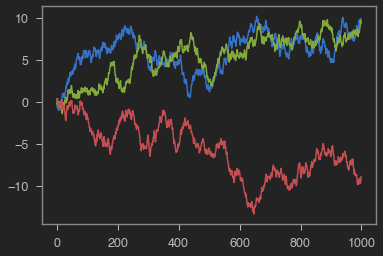

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,-0.064029,-0.187251,0.303678
1,-0.103333,0.049159,0.108442
2,-0.249687,0.340957,-0.306920
3,-0.015855,0.431674,0.178829
4,0.053624,-0.022890,0.003834
...,...,...,...
95,-0.501659,-3.899030,4.202362
96,-0.382458,-3.430652,4.138802
97,-0.594034,-3.259342,3.869929
98,-0.592312,-3.736122,3.754584


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.225443,0.495079,0.266888,0.237845,-0.135376
1,0.235111,0.715260,0.404169,0.247040,-0.231563
2,-0.121572,0.848589,0.011476,0.409661,-0.125579
3,0.052092,0.946320,-0.175079,0.331730,-0.081897
4,0.377631,1.133316,-0.170696,0.504423,-0.302148
...,...,...,...,...,...
95,4.430912,-1.651682,4.294701,-1.119894,0.535001
96,3.978308,-1.506054,4.059265,-1.242032,0.986208
97,3.659264,-1.911232,3.916644,-0.933860,1.263304
98,3.695991,-1.521448,3.888495,-0.647393,1.537150


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.167169,-0.122440,-0.020672,-0.370989,-0.620207,-0.632628,-0.215316,-0.518089,-0.257057,-0.273039,...,1.079513,1.147076,1.276095,1.577499,1.376832,1.514807,1.503482,1.484534,1.915935,2.391730
var_1,0.175078,0.043210,0.207709,0.347164,0.787345,0.304263,0.435274,0.261070,0.573473,0.447817,...,-0.300461,-0.617851,-1.060647,-0.738743,-1.064719,-1.311932,-1.715648,-1.976918,-1.901620,-1.624876
var_2,0.391622,0.155040,0.575412,0.223710,0.066955,-0.260790,-0.495199,-0.004071,-0.384896,-0.051205,...,-1.050112,-0.853730,-1.075730,-0.627827,-0.435007,-0.693213,-0.264761,-0.448998,-0.259671,-0.568783
var_3,0.310898,0.568155,0.406690,0.461446,0.637029,0.387925,-0.096049,-0.240817,-0.373891,-0.082941,...,1.247941,1.597064,1.721077,1.613965,1.366677,1.075763,1.290754,1.256037,1.310644,1.766944
target,0.054497,0.490115,0.436116,0.728922,0.319069,0.528908,0.614870,1.045902,0.654789,0.952380,...,2.983811,3.461328,3.849457,4.077245,4.288832,4.438861,4.041723,4.168998,3.700079,3.830120


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.046010,-0.062262,-0.107600,0.307901,0.296288,0.478333,0.865263,0.372890,0.165179,0.517620,...,-3.484731,-3.038657,-3.217017,-3.116842,-3.084037,-2.833809,-3.195348,-3.538249,-3.684178,-3.414439
var_1,-0.035898,0.262409,0.010344,-0.248266,-0.717571,-0.873287,-1.047832,-1.113964,-0.933831,-1.014337,...,-3.550881,-3.249723,-2.893326,-2.818922,-2.604356,-2.639393,-2.209845,-2.519616,-2.115066,-1.905204
var_2,0.254736,0.071666,0.100163,0.224841,0.474766,0.415278,0.165137,0.220558,0.089717,0.436308,...,-1.339996,-0.907272,-0.714625,-0.380746,0.060768,-0.154989,0.208046,-0.105995,0.335746,-0.146861
var_3,0.074094,-0.371418,0.122476,0.308150,0.378970,0.857746,0.458172,0.573585,0.563356,0.266324,...,-1.024972,-1.352298,-1.622417,-2.059975,-2.233862,-2.063522,-1.728895,-2.213718,-2.496252,-2.485221
target,-0.047225,-0.433698,-0.280648,0.067745,-0.197009,-0.659489,-0.771335,-1.109240,-0.637453,-1.101549,...,-1.801978,-1.787870,-2.228421,-2.651321,-3.137533,-3.557810,-3.453665,-3.105976,-3.581055,-3.714588


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.474264,0.149802,-0.224433,0.327208,-0.050385
1,-0.577398,0.541168,0.114492,0.390015,0.424128
2,-0.980854,0.558159,-0.236266,0.011408,0.426545
3,-0.549804,0.189537,0.081759,-0.242543,0.331732
4,-0.207806,-0.272613,-0.341573,-0.725975,0.589744
...,...,...,...,...,...
95,-1.854666,1.942374,-2.553894,-3.893777,-3.359449
96,-1.915801,2.410578,-2.873610,-4.319009,-3.556577
97,-1.486889,2.224744,-2.833786,-4.767698,-3.407741
98,-1.856582,2.272610,-2.873159,-4.838606,-3.491254


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            else: pv(f'cannot use {unique_id_cols} = {v} due to not having enough records', verbose)

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,42553,425512,4255102,42551000,425510000,4255100000,42551000000,425510000000,4255100000000,42551000000000,42551,2,3,B,142555
1,25629,256290,2562900,25629000,256290000,2562900000,25629000000,256290000000,2562900000000,25629000000000,25629,0,0,A,25629
2,26655,266550,2665500,26655000,266550000,2665500000,26655000000,266550000000,2665500000000,26655000000000,26655,0,0,A,26655
3,49164,491640,4916400,49164000,491640000,4916400000,49164000000,491640000000,4916400000000,49164000000000,49164,0,1,A,49164
4,39196,391960,3919600,39196000,391960000,3919600000,39196000000,391960000000,3919600000000,39196000000000,39196,0,1,A,39196


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199982, 10, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.TSBERT.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Co